In [1]:
import torch
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import joblib
import sys
import numpy as np
import json
import time
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, precision_score, roc_auc_score,
    top_k_accuracy_score
)


CLIP_FEATURES_DIR = "clip_features"
VAL = CLIP_FEATURES_DIR + "/val_features.pt"
SCALER = "scaler_model.joblib"
PCA = "pca_model.joblib"
LIME = "top_k_lime_indices.joblib"


MAX_EPOCHS = 500
EARLY_STOPPING = 500

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


In [2]:
def load_features(file_path):
    data = torch.load(file_path)
    return data["image_features"], data["text_features"], data["filenames"], data["labels"]


# Load train and validation features
val_img_features, val_txt_features, _, val_labels = load_features(VAL)

In [3]:
# Combine image and text features for training
X_val = torch.cat((val_img_features, val_txt_features), dim=1)

# Flatten features into a 2D matrix (samples x features)
X_val = X_val.view(X_val.size(0), -1).numpy()

# Print the shape of the features
print(f"X_val shape: {X_val.shape}")

# Convert labels to NumPy arrays
y_val = val_labels.numpy()  

# Load scaler and PCA models
scaler = joblib.load(SCALER)
pca = joblib.load(PCA)
lime = joblib.load(LIME)

# Scale and transform the features
X_val_scaled = scaler.transform(X_val)
X_val_pca = pca.transform(X_val_scaled)
X_val_lime = X_val_scaled[:, lime]

X_val shape: (1985, 1024)


In [4]:
from classifiers import (
    SVMClassifier, RBFClassifier, RandomForestClassifier, NaiveBayesClassifier, 
    LogisticRegressionClassifier, LDAClassifier, KNNClassifier, DecisionTreeClassifier,
    AdaBoostClassifier, GBMClassifier, XGBoostClassifier
)

from ensembler import EnsemblerClassifier

# Instantiate classifiers
classifiers = [
    SVMClassifier(), RBFClassifier(), RandomForestClassifier(), NaiveBayesClassifier(),
    LogisticRegressionClassifier(), LDAClassifier(), KNNClassifier(),
    DecisionTreeClassifier(), AdaBoostClassifier(), GBMClassifier(),
    XGBoostClassifier()
]

for clf in classifiers:
    clf.load()

Loaded model from: models_pca/SVM.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/RBF.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/RandomForest.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/NaiveBayes.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/LogisticRegression.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/LDA.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/KNN.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/DecisionTree.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/AdaBoost.joblib
Loaded label encoder from: models_pca/label_encoder.joblib
Loaded model from: models_pca/GBM.joblib
Loaded label e

In [5]:
from ensembler import WeightGeneratorNN, train_step

model = WeightGeneratorNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [6]:
#from tqdm import trange
#
#torch.autograd.set_detect_anomaly(True)
#
#
#train_history = []
#best_score = -float("inf")
#
## Initialize tqdm progress bar instance
#pbar = trange(MAX_EPOCHS, desc="Training")
#
#for epoch in pbar:
#    input_params = torch.rand(1, 7, device=DEVICE)
#
#    score, loss = train_step(
#        model, optimizer, input_params,
#        X_val_pca, y_val, classifiers,
#        device=DEVICE, sparsity_coeff=0.01
#    )
#    train_history.append((score, loss))
#
#    # ✅ Update the progress bar description each epoch
#    pbar.set_description(f"Epoch {epoch + 1} | Score: {score:.4f} | Loss: {loss:.4f}")
#
#    # Early stopping logic
#    if score > best_score:
#        best_score = score
#        epochs_without_improvement = 0
#        torch.save(model.state_dict(), "best_weight_generator.pt")
#    else:
#        epochs_without_improvement += 1
#
#    if epochs_without_improvement >= EARLY_STOPPING:
#        print(f"\nEarly stopping at epoch {epoch + 1}")
#        break
#
## Save final model
#torch.save(model.state_dict(), "final_weight_generator_hm.pt")



In [ ]:
import os
from tqdm import trange

# Ensure nn_models directory exists
os.makedirs("nn_models", exist_ok=True)

# Define metric names
metrics = ["acc", "recall", "f1", "precision", "top5", "auc", "time"]

torch.autograd.set_detect_anomaly(True)

for i, metric in enumerate(metrics):
    print(f"\nStarting training for metric: {metric.upper()}")

    # Reset model and optimizer here for each training loop
    model = WeightGeneratorNN().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_history = []
    best_score = -float("inf")
    epochs_without_improvement = 0

    # Training loop
    pbar = trange(MAX_EPOCHS, desc=f"Training {metric}")

    for epoch in pbar:
        input_params = torch.zeros(1, 7, device=DEVICE)
        input_params[0, i+4] = 1.0  # One-hot input

        score, loss = train_step(
            model, optimizer, input_params,
            X_val_pca, y_val, classifiers,
            device=DEVICE, sparsity_coeff=0.01
        )
        train_history.append((score, loss))

        pbar.set_description(f"Epoch {epoch + 1} | {metric.upper()} Score: {score:.4f} | Loss: {loss:.4f}")

        if score > best_score:
            best_score = score
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f"nn_models/best_{metric}_hm.pt")
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= EARLY_STOPPING:
            print(f"Early stopping at epoch {epoch + 1} for metric {metric.upper()}")
            break

    torch.save(model.state_dict(), f"nn_models/final{metric}_hm.pt")



Starting training for metric: TOP5


Epoch 500 | TOP5 Score: 0.8972 | Loss: 1.1541: 100%|██████████| 500/500 [1:36:27<00:00, 11.57s/it]



Starting training for metric: AUC


Epoch 500 | AUC Score: 0.9354 | Loss: 0.0683: 100%|██████████| 500/500 [2:12:53<00:00, 15.95s/it]  



Starting training for metric: TIME


Epoch 500 | TIME Score: 0.8827 | Loss: 0.2090: 100%|██████████| 500/500 [12:17<00:00,  1.48s/it]


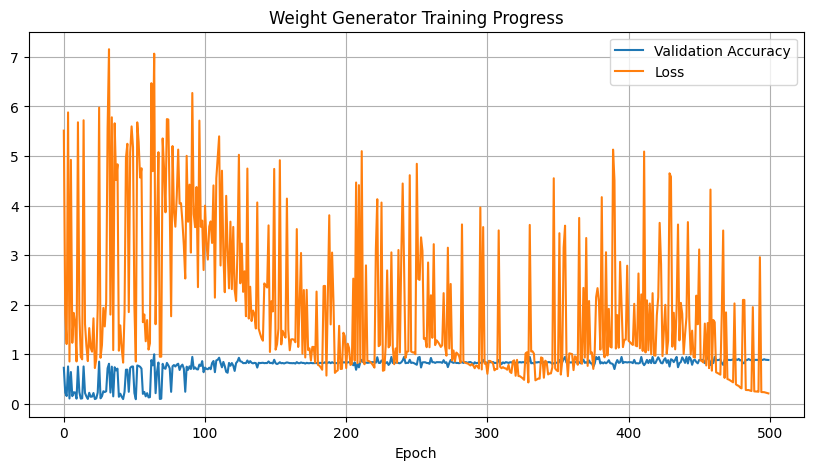

In [8]:
scores, losses = zip(*train_history)
plt.figure(figsize=(10, 5))
plt.plot(scores, label="Validation Accuracy")
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.legend()
plt.title("Weight Generator Training Progress")
plt.grid()
plt.show()